In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from sklearn import metrics

In [2]:
# Read secret JSON with api_keys
import json

with open ('data/secret.json', 'r') as f:
    secret = json.load(f)

In [3]:
# Select random state for project
random_state = 42

In [4]:
# Read csv income data as dataframe and show head 5 
hotels_df = pd.read_csv('data/hotels.csv')
hotels_df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [5]:
# Checking data frame size and information about type of data
print(f'Data frame size: {hotels_df.shape}')
print()
display(hotels_df.info())

Data frame size: (386803, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                        

None

In [6]:
print(f"lat column have {round(hotels_df['lat'].isnull().sum() / hotels_df.shape[0] * 100, 2)}% nulls")
print(f"lng column have {round(hotels_df['lng'].isnull().sum() / hotels_df.shape[0] * 100, 2)}% nulls")

lat column have 0.63% nulls
lng column have 0.63% nulls


Data have 0.63% nulls in lat and lng columns.

In [7]:
# Converting review_date to datetime format and check result
hotels_df['review_date'] = pd.to_datetime(hotels_df['review_date'], format='%m/%d/%Y')
hotels_df['review_date'].head(2)

0   2016-02-19
1   2017-01-12
Name: review_date, dtype: datetime64[ns]

In [10]:
# Find hotel unique numbers
print(f"Number of unique hotle names: {hotels_df['hotel_name'].nunique()}")

Number of unique hotle names: 1492


In [11]:
# Check date interval
print(f'Last review was: {hotels_df["review_date"].max().date()}')
print(f'First review was: {hotels_df["review_date"].min().date()}')

Last review was: 2017-08-03
First review was: 2015-08-04


In [12]:
# Convert string with tags to list in dataframe
def get_tags_list(tags_string):
    tags_list = tags_string.strip("[]").split(", ")
    tags_list = [tag.strip("' ") for tag in tags_list]
    return tags_list

hotels_df['tags'] = hotels_df['tags'].apply(lambda x: x.lower())
hotels_df['tags'] = hotels_df['tags'].apply(get_tags_list)
# Find unique tags
all_tags = []
for tags_list in hotels_df['tags']:
    all_tags.extend(tags_list)
unique_tags = set(all_tags)

In [13]:
# Display numbers of unique tags and mode tag
print(f'Number of unique tags: {len(unique_tags)}')
from statistics import mode
print(f'Mode tag: {mode(all_tags)}')

Number of unique tags: 2361
Mode tag: leisure trip


In [14]:
# Find numbers of nights 
def get_night_numbers(tags):
    for tag in tags:
        if 'stayed' in tag:
            tag = tag.split(sep=' ')
            return int(tag[1])
        
hotels_df['night_satyed'] = hotels_df['tags'].apply(get_night_numbers)

print(f"Mostly stayed for: {hotels_df['night_satyed'].mode()[0]} nights")

Mostly stayed for: 1.0 nights


In [15]:
# # Remove stayed for from tags
# def remove_stayed_night(tags):
#     tags_list = [tag for tag in tags if not tag.startswith('stayed')]
#     return tags_list

# hotels_df['tags'] = hotels_df['tags'].apply(remove_stayed_night)

In [16]:
# Fill night_satyed NaN as mode for the Hotel
for hotel in hotels_df[hotels_df['night_satyed'].isnull()]['hotel_name'].unique():
    mode_value = hotels_df[hotels_df['hotel_name'] == hotel]['night_satyed'].mode()[0]
    hotels_df.loc[hotels_df['hotel_name'] == hotel, 'night_satyed'] = hotels_df[hotels_df['hotel_name'] == hotel]['night_satyed'].fillna(mode_value)

In [17]:
# Create country column
hotels_df['country'] = hotels_df['hotel_address'].apply(lambda x: x.split(sep=' ')[-1])
hotels_df['country'] = hotels_df['country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

In [18]:
# Convert to integer days_since_review column
hotels_df['days_since_review'] = hotels_df['days_since_review'].apply(lambda x: int(x.split(sep=' ')[0]))

In [19]:
# Import time library
import time
# Import OpenCageGeocode for fill nulls in lat and lng
from opencage.geocoder import OpenCageGeocode

key = secret['API_KEY_OPENCAGE']
geocoder = OpenCageGeocode(key)
# Get latitude and longtitude from OpenCageGeocode api
for address in hotels_df[hotels_df['lat'].isnull()]['hotel_address'].unique():
    query = address
    results = geocoder.geocode(query)
    # print(results[0]['geometry']['lat'])
    # print(results[0]['geometry']['lng'])
    lat = float(results[0]['geometry']['lat'])
    lng = float(results[0]['geometry']['lng'])
    hotels_df.loc[hotels_df['hotel_address'] == address, 'lat'] = lat
    hotels_df.loc[hotels_df['hotel_address'] == address, 'lng'] = lng
    # 1 second pause becouse api accept 1 request per second at free subscription
    time.sleep(1)

In [20]:
hotels_df[hotels_df['positive_review'] =='No Positive'].shape[0]/hotels_df.shape[0]

0.06950566567477501

In [164]:
test_3_df = hotels_df.copy()

In [165]:
test_3_df['negative_review'] = test_3_df['negative_review'].apply(lambda x: x.lower())
test_3_df['positive_review'] = test_3_df['positive_review'].apply(lambda x: x.lower())

In [166]:
# Get nothing positive
def get_positive_nothing(review):
    if review == 'no positive' or review == ' nothing ' or review == ' n a' or review == ' nothing' or review == ' ':
        return 1
    else: 
        return 0
    
test_3_df['positive_nothing'] = test_3_df['positive_review'].apply(get_positive_nothing)

# Get nothing negative
def get_negative_nothing(review):
    if review == 'no negative' or review == ' nothing ' or review == ' n a' or review == ' nothing' or review == ' ':
        return 1
    else: 
        return 0

test_3_df['negative_nothing'] = test_3_df['negative_review'].apply(get_negative_nothing)

# Get location from reviews
def get_review_location(review):
    if 'location' in review:
        return 1
    else:
        return 0
    
test_3_df['positive_location'] = test_3_df['positive_review'].apply(get_review_location)
test_3_df['negative_location'] = test_3_df['negative_review'].apply(get_review_location)

# Get everything from reviews
def get_everything_review(review):
    if 'everything' in review:
        return 1
    else:
        return 0
    
test_3_df['positive_everything'] = test_3_df['positive_review'].apply(get_everything_review)
test_3_df['negative_everything'] = test_3_df['negative_review'].apply(get_everything_review)

# Get breakfast from reviews
def get_breakfast_reviews(review):
    if 'breakfast' in review or 'brekfast' in review:
        return 1
    else:
        return 0
    
test_3_df['positive_breakfast'] = test_3_df['positive_review'].apply(get_breakfast_reviews)
test_3_df['negative_breakfast'] = test_3_df['negative_review'].apply(get_breakfast_reviews)

# Get leisure trip from tags
def get_leisure_trip(tags):
    if 'leisure trip' in tags:
        return 1
    else:
        return 0
    
test_3_df['leisure_trip'] = test_3_df['tags'].apply(get_leisure_trip)

In [167]:
test_3_df['reviewer_nationality'].nunique()

225

In [168]:
test_4_df = test_3_df.drop(['hotel_address', 'review_date', 'positive_review', 'tags', 'negative_review'], axis=1)

In [169]:
test_4_df = pd.get_dummies(test_4_df, columns=['country'])

In [170]:
test_4_df = test_4_df.drop(columns=['lat', 'lng'], axis=1)

In [171]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

test_4_df['nat_encode'] = encoder.fit_transform(test_4_df['reviewer_nationality'])
test_4_df['hotel_encode'] = encoder.fit_transform(test_4_df['hotel_name'])

In [172]:
test_4_df = test_4_df.drop(columns=['hotel_name', 'reviewer_nationality'], axis=1)

In [173]:
test_4_df = test_4_df.drop(columns=['additional_number_of_scoring'], axis=1)

Text(0.5, 1.0, 'Data correlation heatmap')

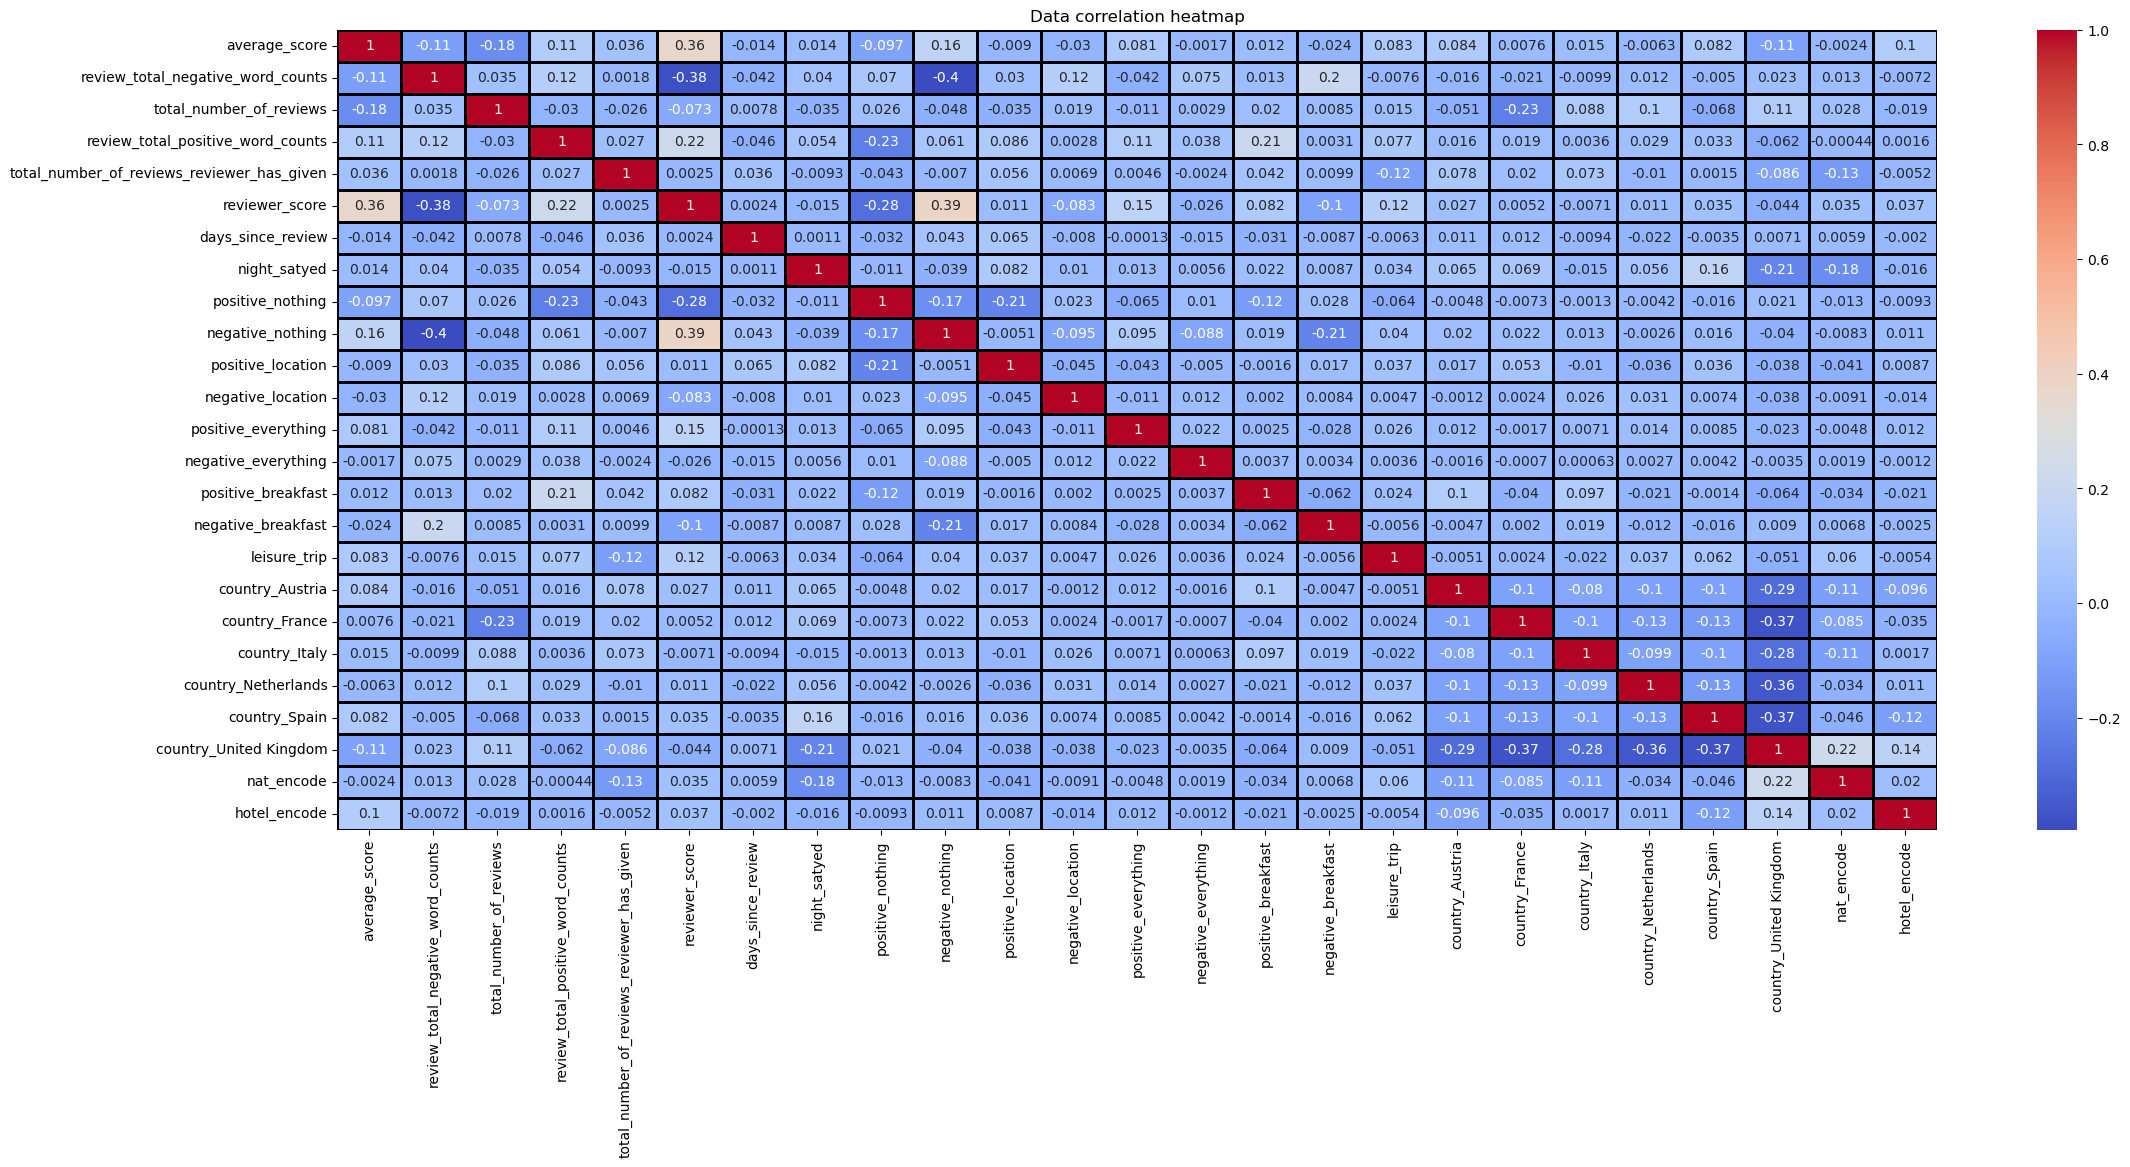

In [174]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([1,1,1,1])
sns.heatmap(test_4_df.corr(), annot=True, linecolor='black', linewidths=1, cmap='coolwarm', ax=ax)
ax.set_title('Data correlation heatmap')
# experiment.log_figure(figure=plt)

In [175]:
test_4_df.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,night_satyed,positive_nothing,negative_nothing,...,negative_breakfast,leisure_trip,country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,nat_encode,hotel_encode
0,8.4,3,1994,4,7,10.0,531,2.0,0,0,...,0,1,False,False,False,False,False,True,213,1366
1,8.3,3,1361,2,14,6.3,203,1.0,0,0,...,1,0,False,False,False,False,False,True,213,975
2,8.9,6,406,0,14,7.5,289,3.0,1,0,...,0,1,False,True,False,False,False,False,42,909
3,7.5,0,607,11,8,10.0,681,1.0,0,1,...,0,1,False,True,False,False,False,False,213,983
4,8.5,4,7586,20,10,9.6,516,6.0,0,0,...,0,0,False,False,False,True,False,False,160,349


In [158]:
# test_4_df = test_4_df.drop(columns=['nat_encode', 'hotel_encode'], axis=1)

In [163]:
test_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   total_number_of_reviews                     386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   reviewer_score                              386803 non-null  float64
 6   days_since_review                           386803 non-null  int64  
 7   night_satyed                                386803 non-null  float64
 8   positive_nothing                            386803 non-null  int64  
 9   negative_nothing                            386803 non-null  int64  
 

In [193]:
col_names = test_4_df.columns

In [194]:
from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
test_5_df = r_scaler.fit_transform(test_4_df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
test_5_df = pd.DataFrame(test_5_df, columns=col_names)


In [195]:
# Split dataframe for train and testing model
#X - data with hotel information, y - target column(rating)
X = test_5_df.drop(['reviewer_score'], axis=1)# Scoring predict quality
y = test_5_df['reviewer_score']
# Upload instrumen for spliting data
from sklearn.model_selection import train_test_split
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [179]:
col_names = X_train.columns

Text(0.5, 1.0, 'Data correlation heatmap')

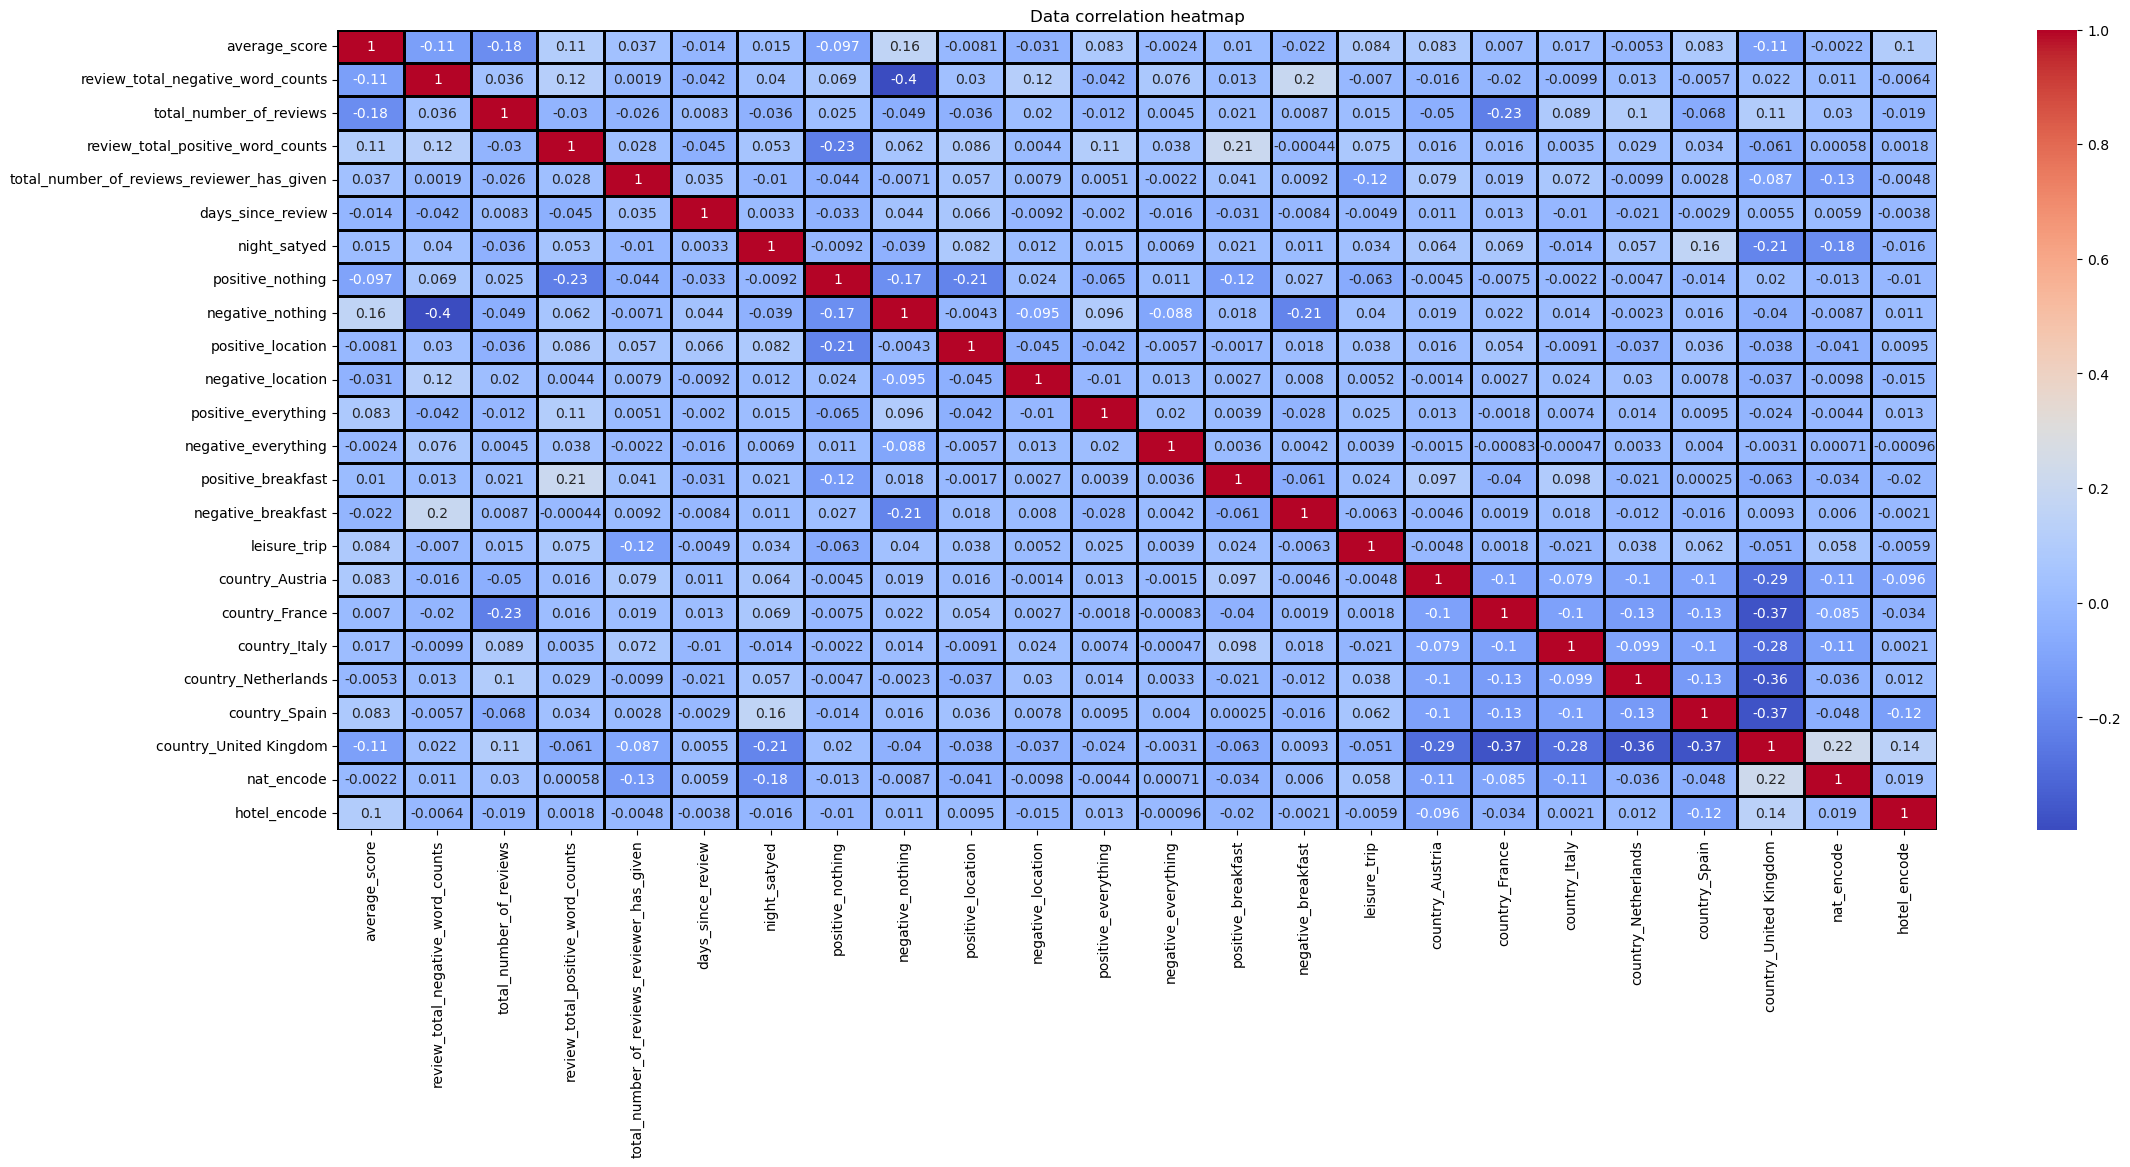

In [196]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([1,1,1,1])
sns.heatmap(X_train.corr(), annot=True, linecolor='black', linewidths=1, cmap='coolwarm', ax=ax)
ax.set_title('Data correlation heatmap')
# experiment.log_figure(figure=plt)

In [197]:
# Import libraries for create, train and testing model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# Create model
regr = RandomForestRegressor(n_estimators=100)
# Train the model on the test data
regr.fit(X_train, y_train)
# Use model for predict rating on the test data
y_pred = regr.predict(X_test)


In [198]:
# Scoring predict quality
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
# Log metrics
metrics_ = {'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred)}
# experiment.log_metrics(metrics_)

MAPE: 126208499271669.14


In [ ]:
# New copy of input data frame
test_1_df = hotels_df.copy()


In [ ]:
test_1_df['review_date_seconds'] = test_1_df['review_date'].apply(lambda x: x.timestamp())

In [ ]:
# Get trip type from tags
def get_trip_type(tags):
    if tags[0] == 'leisure trip' or tags[0] == 'business trip':
        return tags[0]
    else:
        return None
    
test_1_df['trip_type'] = test_1_df['tags'].apply(get_trip_type)

In [ ]:
# Fill nulls in trip types by mode value for the hotel address
for address in test_1_df[test_1_df['trip_type'].isnull()]['hotel_address'].unique():
    mode_value = test_1_df[test_1_df['hotel_address'] == address]['trip_type'].mode()[0]
    test_1_df.loc[test_1_df['hotel_address'] == address, 'trip_type'] = test_1_df[test_1_df['hotel_address'] == address]['trip_type'].fillna(mode_value)

In [ ]:
test_1_df = pd.get_dummies(test_1_df, columns=['trip_type', 'country'])

In [ ]:
test_2_df = test_1_df.drop(columns=['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'review_date_seconds', 'trip_type_business trip', 'additional_number_of_scoring', 'lat', 'lng'])

In [ ]:
test_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   total_number_of_reviews                     386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   reviewer_score                              386803 non-null  float64
 6   days_since_review                           386803 non-null  int64  
 7   night_satyed                                386803 non-null  float64
 8   trip_type_leisure trip                      386803 non-null  bool   
 9   country_Austria                             386803 non-null  bool   
 

In [ ]:
# Creating experiment with api key
experiment = Experiment(
    api_key= secret['API_KEY_COMET'],
    project_name='hotels-rate-prediction',
    workspace=secret['WORKSPACE']
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/smoke0leg/hotels-rate-prediction/5d69ce894b3d4db790b99cb2abbd16a9
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to c

{'web': 'https://www.comet.com/api/image/download?imageId=2d897f5db646404ab3f91aec1a8427e0&experimentKey=b57d76d5a4dc40afa8f2ae1e01572f79',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=2d897f5db646404ab3f91aec1a8427e0&experimentKey=b57d76d5a4dc40afa8f2ae1e01572f79',
 'imageId': '2d897f5db646404ab3f91aec1a8427e0'}

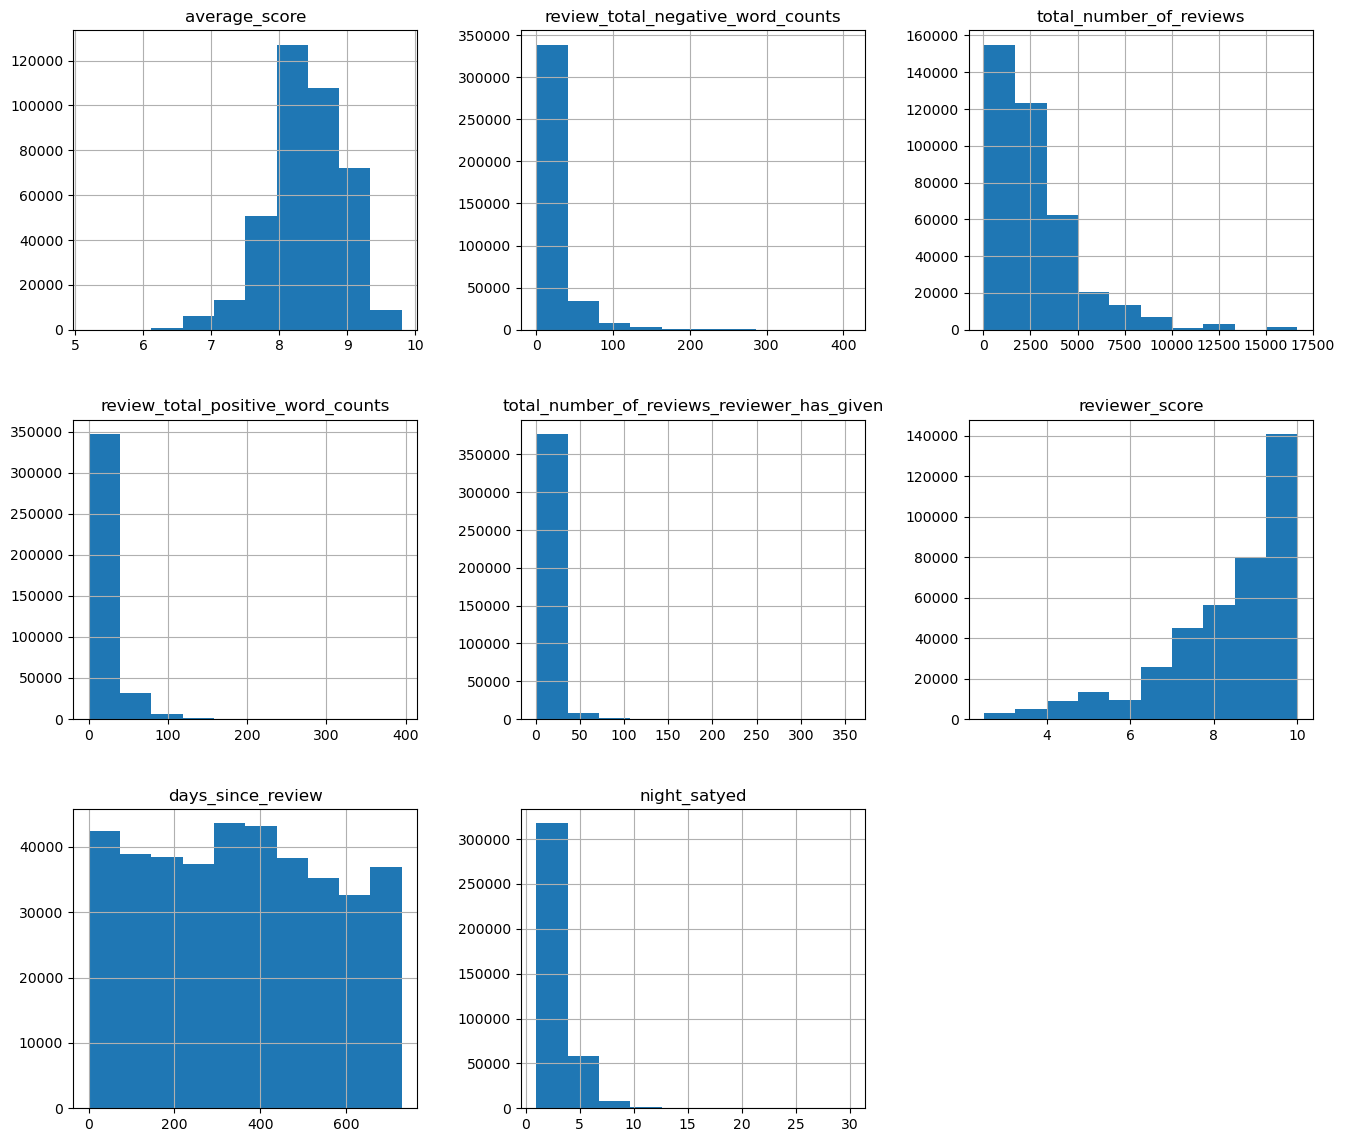

In [ ]:
test_2_df.hist(figsize=(16,14))
# experiment.log_figure(figure=plt)

{'web': 'https://www.comet.com/api/image/download?imageId=b39d0c5b65fc40ceb95a98b991aeabda&experimentKey=b57d76d5a4dc40afa8f2ae1e01572f79',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b39d0c5b65fc40ceb95a98b991aeabda&experimentKey=b57d76d5a4dc40afa8f2ae1e01572f79',
 'imageId': 'b39d0c5b65fc40ceb95a98b991aeabda'}

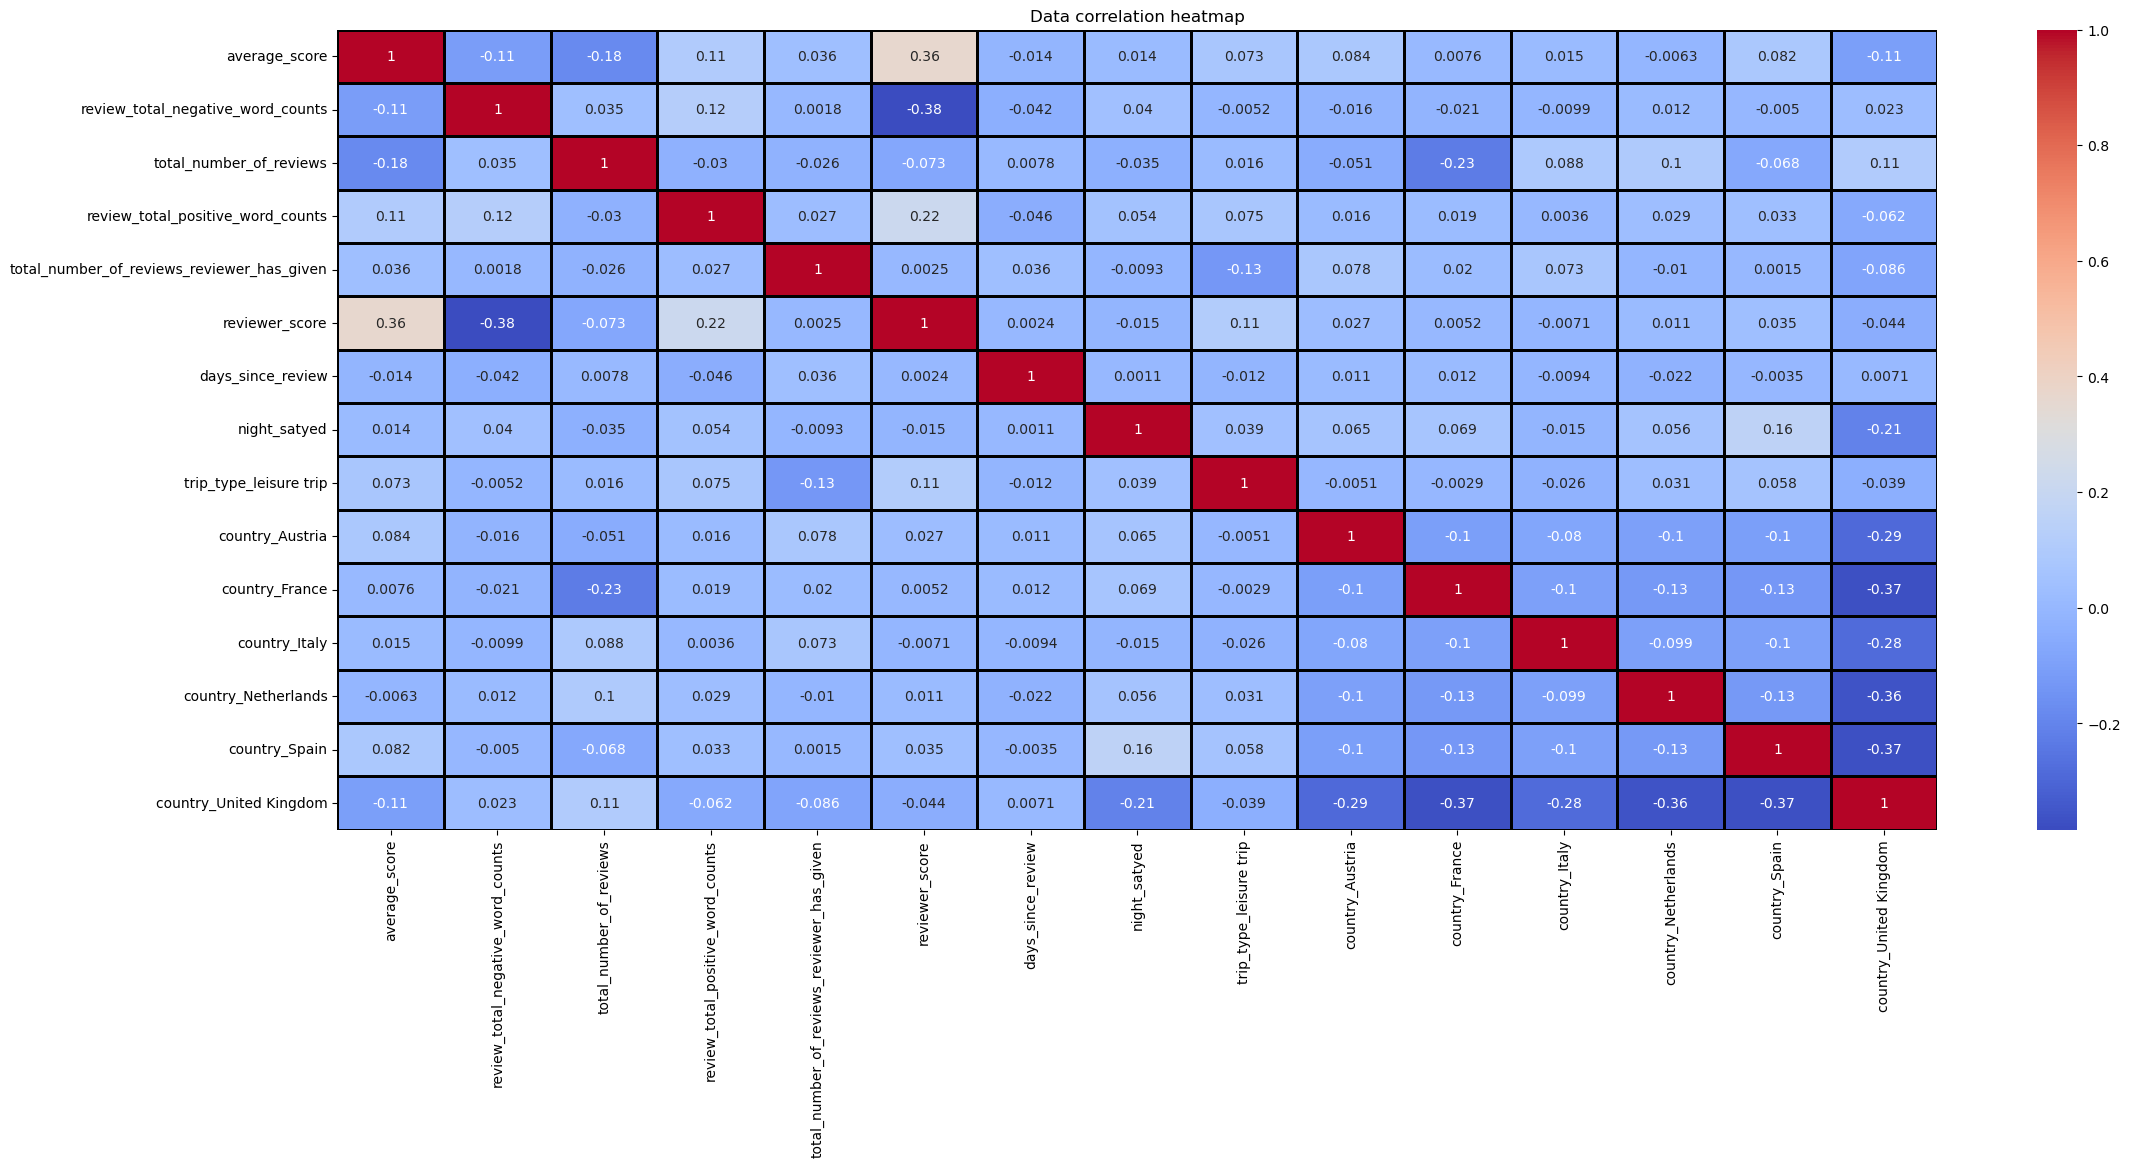

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([1,1,1,1])
sns.heatmap(test_2_df.corr(), annot=True, linecolor='black', linewidths=1, cmap='coolwarm', ax=ax)
ax.set_title('Data correlation heatmap')
# experiment.log_figure(figure=plt)

In [ ]:
# Split dataframe for train and testing model
#X - data with hotel information, y - target column(rating)
X = test_2_df.drop(['reviewer_score'], axis=1)# Scoring predict quality
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
y = test_2_df['reviewer_score']
# Upload instrumen for spliting data
from sklearn.model_selection import train_test_split
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

MAPE: 0.14133735289945945


In [ ]:
# # Log params
# params = {'random_state': random_state,
#           'model_type': 'RandomForestRegressor'}
# experiment.log_parameters(params)

In [ ]:
# # Import libraries for create, train and testing model
# from sklearn.ensemble import RandomForestRegressor
# from sklearn import metrics
# # Create model
# regr = RandomForestRegressor(n_estimators=100)
# # Train the model on the test data
# regr.fit(X_train, y_train)
# # Use model for predict rating on the test data
# y_pred = regr.predict(X_test)


In [ ]:
# # Scoring predict quality
# print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
# # Log metrics
# metrics_ = {'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred)}
# # experiment.log_metrics(metrics_)

MAPE: 0.1370161025810473


In [ ]:
# experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/smoke0leg/hotels-rate-prediction/b57d76d5a4dc40afa8f2ae1e01572f79
COMET INFO:   Metrics:
COMET INFO:     MAPE : 0.1370161025810473
COMET INFO:   Parameters:
COMET INFO:     model_type   : RandomForestRegressor
COMET INFO:     random_state : 42
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 2
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before 

In [ ]:
test_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [ ]:
num_cols = ['additional_number_of_scoring', 'review_date_seconds', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'night_satyed']

In [ ]:
cat_cols = ['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'country']